# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [12]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)
import scipy.stats as st

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [2]:
# go with B

## Option B: Synthetic Generator (Use if you don't have data ready)

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


## Feature Engineering

In [10]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
mu20 = df['ret'].rolling(20).mean()
sd20 = df['ret'].rolling(20).std()
df['ret_z20'] = ((df['ret'] - mu20) / sd20).shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,y_next_ret,y_up,roll_vol_20,mom_5,ret_z20
2021-01-29,100.198878,0.016949,0.016807,-0.014854,-0.003707,0.001845,1,0.007370,-0.018533,-1.801940
2021-02-01,100.383751,0.001845,0.001843,0.016949,0.002509,-0.003565,0,0.008455,0.012547,2.090596
2021-02-02,100.025880,-0.003565,-0.003571,0.001845,0.001706,0.020804,1,0.008429,0.008529,0.268365
2021-02-03,102.106835,0.020804,0.020591,-0.003565,0.000685,-0.000154,0,0.008453,0.003424,-0.347615
2021-02-04,102.091126,-0.000154,-0.000154,0.020804,0.004236,-0.014106,0,0.009675,0.021179,2.130277


## Split

In [5]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

In [ ]:
# Track 1: Forecasting returns(pick this one)
reg = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())])
reg.fit(X_tr, y_tr_reg)
pred = reg.predict(X_te)
rmse = mean_squared_error(y_te_reg, pred) **0.5
print('RMSE:', rmse)

RMSE: 0.014524324812974157


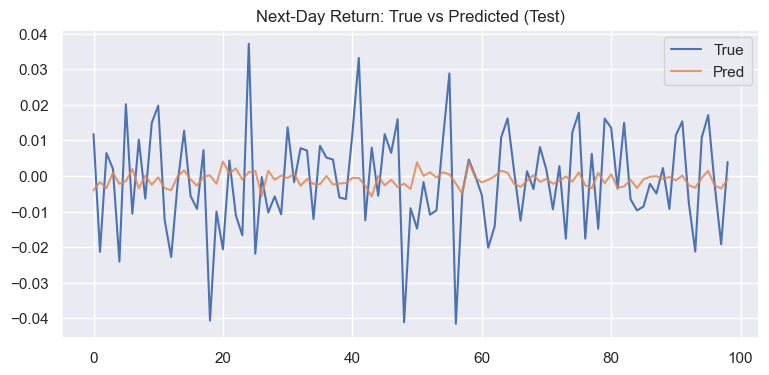

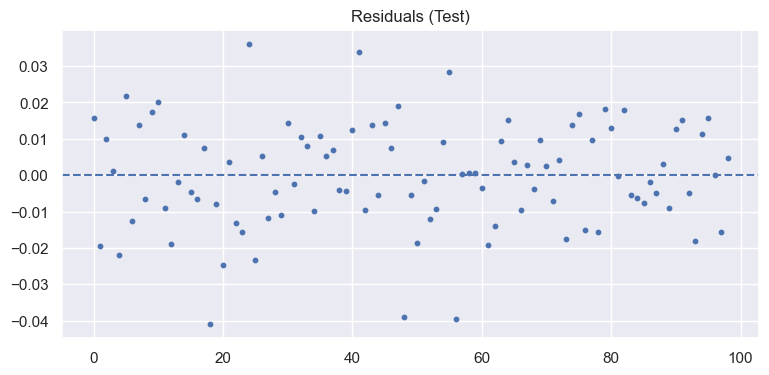

In [11]:
fig, ax = plt.subplots()
y_te_reg.reset_index(drop=True).plot(ax=ax, label='True')
pd.Series(pred).plot(ax=ax, label='Pred', alpha=0.8)
ax.set_title('Next-Day Return: True vs Predicted (Test)')
ax.legend(); plt.show()

resid = y_te_reg.values - pred
fig, ax = plt.subplots()
ax.scatter(range(len(resid)), resid, s=10)
ax.axhline(0, ls='--')
ax.set_title('Residuals (Test)'); plt.show()

In [ ]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

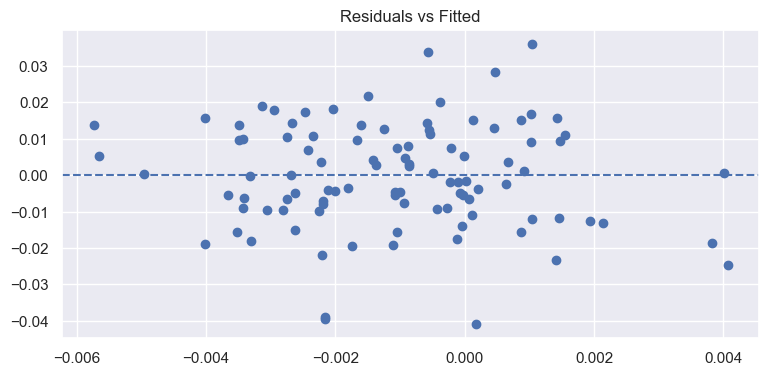

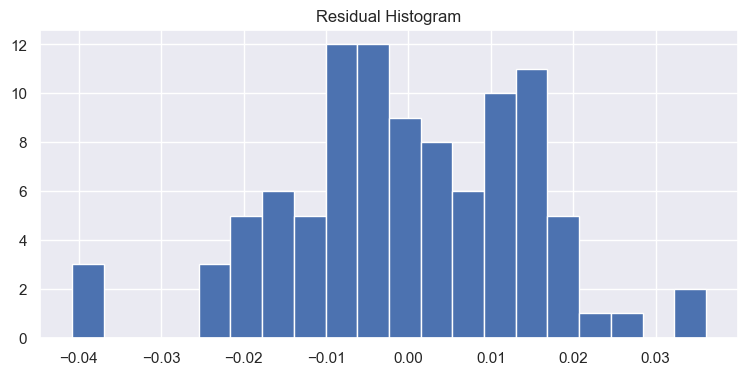

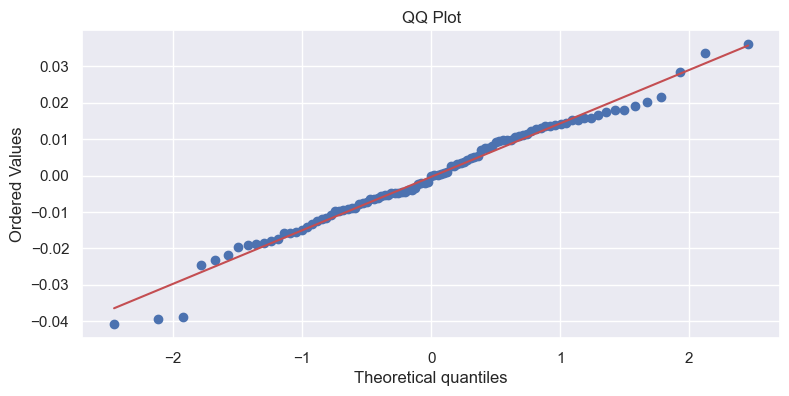

In [13]:
fitted = pred
plt.figure(); plt.scatter(fitted, resid); plt.axhline(0, ls='--'); plt.title('Residuals vs Fitted'); plt.show()
plt.figure(); plt.hist(resid, bins=20); plt.title('Residual Histogram'); plt.show()
plt.figure(); st.probplot(resid, dist='norm', plot=plt); plt.title('QQ Plot'); plt.show()

## Interpretation (Markdown)
- What worked?
This model did a good job in predicting the return(randomly scattered around 0 in Residual vs Fitted plot).
- Where might assumptions fail?
The residual histogram does not look exactly like bell shape, suggeting more investigation is needed regarding normality.
- How would you extend features or model?
Given the trend in residual histogram, I will try log transformation to refit the data. 

### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.